In [1]:
import sys
import localSettings as ls
print(ls.main_path)

/home/david/data/searchingfornues/v08_00_00_33/cc0pinp/0220/


In [2]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 02262020


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
SHRCALIBFACTOR = 1.03 # scale data by this amount

In [5]:
# Doing Run3?
ISRUN3 = True
ALLDATA = True

In [6]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [7]:
fold = "nuselection"
foldmc = "searchingfornues"
tree = "NeutrinoSelectionFilter"

PI0DIR = ''

BNB = ""
EXT = ""
NU  = ""
NUE = ""
DRT = ""
PI0 = ""
CCPI0 = ""

DATAFLDR = "pi0/"
MCFLDR = "pi0/" # "../0218/run3/"

if ALLDATA:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_ALL_pi0_reco2'
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_ALL_pi0_reco2'
    if (ISRUN3):
        NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2_pi0sel'
        NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2_pi0sel'
        DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2_pi0sel'
    else:
        NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run1_reco2_reco2_pi0sel'
        NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2_pi0sel'
        DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2_pi0sel'
    

elif ISRUN3:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_G1_pi0_reco2'
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_RUN3_pi0_reco2'
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2_pi0sel'
    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2_pi0sel'
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2_pi0sel'
    #NCPI0 = 'prodgenie_nc_pi0_uboone_overlay_mcc9.1_v08_00_00_26_run3_G_reco2'
    #CCPI0 = 'prodgenie_cc_pi0_uboone_overlay_v08_00_00_26_run3_G_reco2'
    #CCNOPI = 'prodgenie_CCmuNoPi_overlay_mcc9_v08_00_00_33_run3_reco2_reco2'
    #NCCPI = 'prodgenie_NCcPiNoPi0_overlay_mcc9_v08_00_00_33_New_run3_reco2_reco2'
    #NCNOPI = 'prodgenie_ncnopi_overlay_mcc9_v08_00_00_33_new_run3_reco2_reco2'
    #MCFLDR = "run3/"
    
else:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_C1_pi0_reco2'
    #BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_C1_beam_good_reco2_5e19' # 5E19
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_RUN1_pi0_reco2'
    #EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_C1_all_reco2' # 5E19
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run1_reco2_reco2_pi0sel'
    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2_pi0sel'
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2_pi0sel'
    #NCPI0 = 'prodgenie_nc_pi0_uboone_overlay-v08_00_00_26_run1_reco2_reco2'
    #CCPI0 = 'prodgenie_cc_pi0_uboone_overlay_v08_00_00_26_run1_reco2'
    #CCNOPI = 'prodgenie_CCmuNoPi_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'
    #NCCPI = 'prodgenie_NCcPiNoPi0_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'
    #NCNOPI = 'prodgenie_ncnopi_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'
    #MCFLDR = "run1/"
    
mc = uproot.open(ls.main_path+MCFLDR+NU+".root")[foldmc][tree]
#ncpi0 = uproot.open(ls.main_path+MCFLDR+NCPI0+".root")[fold][tree]
#ccpi0 = uproot.open(ls.main_path+MCFLDR+CCPI0+".root")[fold][tree]
#ccnopi = uproot.open(ls.main_path+MCFLDR+CCNOPI+".root")[fold][tree]
#nccpi = uproot.open(ls.main_path+MCFLDR+NCCPI+".root")[fold][tree]
#ncnopi = uproot.open(ls.main_path+MCFLDR+NCNOPI+".root")[fold][tree]
nue = uproot.open(ls.main_path+MCFLDR+NUE+".root")[foldmc][tree]
data = uproot.open(ls.main_path+DATAFLDR+BNB+".root")[fold][tree]
ext = uproot.open(ls.main_path+DATAFLDR+EXT+".root")[fold][tree]
dirt = uproot.open(ls.main_path+MCFLDR+DRT+".root")[foldmc][tree]
lee = uproot.open(ls.main_path+MCFLDR+NUE+".root")[foldmc][tree]

uproot_v = [lee,mc,nue,ext,data,dirt]# [lee,mc,ncpi0,ccpi0,ccnopi,nccpi,ncnopi,nue,ext,data,dirt]

variables = [
    "shr_bkt_pdg", "selected", "nu_pdg",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "category",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nu_e","trk_bkt_pdg","ccnc",
    "mc_pdg", "npi0",
    "run","sub","evt",
    "filter_pi0","pi0_e",
    "trk_id","trk_llr_pid_score_v",
    "interaction",
    "topological_score","trk_len",
    "evnunhits", "nslice", "selected",
    "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
    "slnunhits","slnhits",
    "_opfilter_pe_beam",
    "shr_theta",
    # pi0 variables
    "pi0_radlen1","pi0_radlen2","pi0_dot1","pi0_dot2","pi0_energy1_Y","pi0_energy2_Y",
    "pi0_dedx1_fit_Y","pi0_dedx2_fit_Y","pi0_shrscore1","pi0_shrscore2","pi0_gammadot",
    "pi0_dedx1_fit_V","pi0_dedx2_fit_V","pi0_dedx1_fit_U","pi0_dedx2_fit_U",
    "pi0_mass_Y","pi0_mass_V","pi0_mass_U",
    #"pi0_dir2_x","pi0_dir2_y","pi0_dir2_z","pi0_dir1_x","pi0_dir1_y","pi0_dir1_z",
    "tksh_distance","shr_tkfit_gap10_dedx_Y","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_U",
    "shr_tkfit_2cm_dedx_Y","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_U",
    "tksh_angle","shrmoliereavg","n_showers_contained",
    "shr_score","hits_ratio","CosmicIP","secondshower_Y_nhit","secondshower_Y_dot",
    "secondshower_Y_vtxdist","shr_energy_tot_cali",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2",
    "n_tracks_contained","secondshower_Y_dir","shrclusdir2",
    "shr_tkfit_npoints","shr_tkfit_npointsvalid"
    ]

WEIGHTS = ["weightSpline","weightTune","weightSplineTimesTune"]#, "weightsGenie", "weightsFlux", "weightsReint"]
WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
           "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
           "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]
SYSTEMATICS =  ['weightsFlux','weightsGenie']

nue = nue.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
mc = mc.pandas.df(variables + WEIGHTS + MCFVARS  + SYSTEMATICS, flatten=False)
#ncpi0 = ncpi0.pandas.df(variables + WEIGHTS  + SYSTEMATICS, flatten=False)
#ccpi0 = ccpi0.pandas.df(variables + WEIGHTS  + SYSTEMATICS, flatten=False)
#ccnopi = ccnopi.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
#nccpi = nccpi.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
#ncnopi = ncnopi.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
lee = lee.pandas.df(variables + WEIGHTSLEE + SYSTEMATICS, flatten=False)

In [8]:
#df_v = [lee,mc,ncpi0,ccpi0,ccnopi,nccpi,ncnopi,nue,ext,data,dirt]
df_v = [lee,mc,nue,ext,data,dirt]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["topological_score"])
    df["extdata"] = np.zeros_like(df["topological_score"])
data["bnbdata"] = np.ones_like(data["topological_score"])
ext["extdata"]  = np.ones_like(ext["topological_score"])

In [9]:
#df_v = [lee,mc,ncpi0,ccpi0,ccnopi,nccpi,ncnopi,nue,dirt]
df_v = [lee,mc,nue,dirt]

for i,df in enumerate(df_v):
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    # scale pi0s
    df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] = df['weightSpline'] * df['weightTune'] * 0.7

In [10]:
#nc['weightSplineTimesTune'] =  nc['weightSplineTimesTune']*0.10
#ccpi0['weightSplineTimesTune'] =  ccpi0['weightSplineTimesTune']*0.10

In [ ]:
F = 243. * (23.6/1e6) / 0.60

In [ ]:
#df_v = [lee,mc,ncpi0,ccpi0,ccnopi,nccpi,ncnopi,nue,ext,data,dirt]
df_v = [lee,mc,nue,ext,data,dirt]

F = 1.04

# energy scaling
for i,df in enumerate(df_v):
    df["pi0_mass_Y_calib"] = df['pi0_mass_Y']
    df["pi0_dedx1_fit_Y_calib"] = df['pi0_dedx1_fit_Y'] #* F
    df["pi0_dedx2_fit_Y_calib"] = df['pi0_dedx2_fit_Y'] #* F
    df['pi0_reco_mom'] = np.sqrt(((df['pi0_energy1_Y'] + df['pi0_energy2_Y'])/0.8)**2-135*135)
    
data['pi0_mass_Y_calib'] = data['pi0_mass_Y_calib'] * F
ext['pi0_mass_Y_calib'] = ext['pi0_mass_Y_calib'] * F

data['pi0_dedx1_fit_Y_calib'] = data['pi0_dedx1_fit_Y_calib'] * F 
ext['pi0_dedx1_fit_Y_calib'] = ext['pi0_dedx1_fit_Y_calib'] * F

data['pi0_dedx2_fit_Y_calib'] = data['pi0_dedx2_fit_Y_calib'] * F
ext['pi0_dedx2_fit_Y_calib'] = ext['pi0_dedx2_fit_Y_calib'] * F

In [11]:
#df_v = [lee,mc,ncpi0,ccpi0,ccnopi,nccpi,ncnopi,nue,ext,data,dirt]
df_v = [lee,mc,nue,ext,data,dirt]

SCALE = 0.8

for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['asymm'] = np.abs(df['pi0_energy1_Y']-df['pi0_energy2_Y'])/(df['pi0_energy1_Y']+df['pi0_energy2_Y'])
    df['pi0energy'] = 134.98 * np.sqrt( 2. / ( (1-(df['asymm'])**2) * (1-df['pi0_gammadot']) ) )
    #df['pi0momx'] = df['pi0_energy2_Y']*df['pi0_dir2_x'] + df['pi0_energy1_Y']*df['pi0_dir1_x']
    #df['pi0momy'] = df['pi0_energy2_Y']*df['pi0_dir2_y'] + df['pi0_energy1_Y']*df['pi0_dir1_y']
    #df['pi0momz'] = df['pi0_energy2_Y']*df['pi0_dir2_z'] + df['pi0_energy1_Y']*df['pi0_dir1_z']
    #df['pi0energyraw'] = df['pi0_energy2_Y'] + df['pi0_energy1_Y']
    #df['pi0momanglecos'] = df['pi0momz'] / df['pi0energyraw']
    #df['epicospi'] = df['pi0energy'] * (1-df['pi0momanglecos'])
    #df['boost'] = (np.abs(df['pi0_energy1_Y']-df['pi0_energy2_Y'])/0.8)/(np.sqrt((df['pi0energy'])**2-135**2))
    #df['pi0_mass_Y_corr'] = df['pi0_mass_Y']/0.83
    #df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    #df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    #df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    #df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']


In [12]:
# avoid double-counting of events out of FV in the NC/CC pi0 samples
# not needed anymore since we improved matching with filtered samples
#ncpi0 = ncpi0.query('category != 5')
#ccpi0 = ccpi0.query('category != 5')
#ccnopi = ccnopi.query('category != 5')
#nccpi = nccpi.query('category != 5')
#ncnopi = ncnopi.query('category != 5')

# avoid recycling unbiased ext events (i.e. selecting a slice with little nu content from these samples)
#ccnopi = ccnopi.query('(nslice==0 | (slnunhits/slnhits)>0.2)')
#nccpi = nccpi.query('(nslice==0 | (slnunhits/slnhits)>0.2)')
#ncnopi = ncnopi.query('(nslice==0 | (slnunhits/slnhits)>0.2)')

# add back the cosmic category, for background only
#df_v = [lee,mc,ncpi0,ccpi0,ccnopi,nccpi,ncnopi,nue,ext,data,dirt]
df_v = [lee,mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [13]:
lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11
#ncpi0["is_signal"] = ncpi0["category"] == 11
#ccpi0["is_signal"] = ccpi0["category"] == 11
#ccnopi["is_signal"] = ccnopi["category"] == 11
#nccpi["is_signal"] = nccpi["category"] == 11
#ncnopi["is_signal"] = ncnopi["category"] == 11

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

In [14]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/home/david/Neutrinos/NUE/PELEE3/plotter.py'>

In [15]:
samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext,
    "dirt": dirt,
    #"ncpi0": ncpi0,
    #"ccpi0": ccpi0,
    #"ccnopi": ccnopi,
    #"nccpi": nccpi,
    #"ncnopi": ncnopi,
    "lee": lee
}

scaling = 1
#scaling = 132.0/0.486
#scaling = 132.0/3.9

SPLIT = 1.0

if ALLDATA:
    if (ISRUN3):
        weights = {
            "mc": 4.45e-1 * SPLIT * scaling, #4.44e-1
            "nue":  8.16e-3 * SPLIT * scaling, #7.99e-3,
            "ext": 7.73e-1 * SPLIT * scaling,
            "dirt": 1.83e0 * scaling, # 1.81e0, # 
            "lee": 8.16e-3 * SPLIT * scaling,
            "ncpi0": 5.68e-2 * SPLIT * scaling,
            "ccpi0": 2.07e-2 * SPLIT * scaling,
            "ccnopi": 1.19e-01 * SPLIT * scaling,
            "nccpi": 1.81e-02 * SPLIT * scaling,
            "ncnopi": 4.23e-02 * SPLIT * scaling,
        }
        pot = 5.87e20*scaling
    else:
        weights = {
            "mc": 5.50e-1 * SPLIT * scaling,
            "nue": 1.11e-2 * SPLIT * scaling,
            "ext": 7.73e-1 * SPLIT * scaling,
            "dirt": 1.82e0 * scaling,
            "lee": 1.11e-2 * SPLIT * scaling,
            "ncpi0": 1.33e-2 * SPLIT * scaling,
            "ccpi0": 1.06e-2 * SPLIT * scaling,
            "ccnopi": 1.35e-02 * SPLIT * scaling,
            "nccpi": 4.14e-03 * SPLIT * scaling,
            "ncnopi": 1.08e-02 * SPLIT * scaling,
        }
        pot = 5.87e20*scaling
elif ISRUN3:
    weights = {
        "mc": 1.22e-1 * SPLIT * scaling,
        "nue": 2.24e-3 * SPLIT * scaling,
        "ext": 4.19e-1 * SPLIT * scaling,
        "dirt": 5.03e-1 * scaling,
        "lee": 2.24e-3 * SPLIT * scaling,
        "ncpi0": 5.68e-2 * SPLIT * scaling,
        "ccpi0": 2.07e-2 * SPLIT * scaling,
        "ccnopi": 1.19e-01 * SPLIT * scaling,
        "nccpi": 1.81e-02 * SPLIT * scaling,
        "ncnopi": 4.23e-02 * SPLIT * scaling,
    }
    pot = 1.61e20*scaling
else:
    weights = {
        "mc": 3.79e-2 * SPLIT * scaling,
        "nue": 6.36e-4 * SPLIT * scaling,
        "ext": 3.13e-1 * SPLIT * scaling,
        "dirt": 5.00e-1 * scaling,
        "lee": 6.36e-4 * SPLIT * scaling,
        "ncpi0": 1.33e-2 * SPLIT * scaling,
        "ccpi0": 1.06e-2 * SPLIT * scaling,
        "ccnopi": 1.35e-02 * SPLIT * scaling,
        "nccpi": 4.14e-03 * SPLIT * scaling,
        "ncnopi": 1.08e-02 * SPLIT * scaling,
    }
    pot = 3.34e19*scaling



my_plotter = plotter.Plotter(samples, weights, pot=pot)

In [ ]:
VAR_V = ['pi0_shrscore1','pi0_shrscore2','pi0_dot1','pi0_dot2',\
        'pi0_radlen1','pi0_radlen2','pi0_gammadot',\
        'pi0_energy1_Y','pi0_energy2_Y',\
        'pi0_dedx1_fit_Y','pi0_dedx2_fit_Y']

LABEL_V = ['leading shower score','sub-leading shower score','leading shower vtx alignment [dot-product]',\
          'sub-leading shower vtx alignment [dot-product]','leading shower conversion distance [cm]',\
          'sub-leading shower conversion distance [cm]','di-photon opening angle [rad]','leading shower energy',\
          'sub-leading shower energy',\
          'leading dEdx [MeV/cm]','sub-leading dE/dx [MeV/cm]']

RANGE_V = [(0,0.8),(0,0.8),(0.8,1),(0.8,1),(3,100),(3,100),(0,0.94),(50,500),(20,300),(0,10),(0,10)]

SCORECUT = 0.8 # max track score
DVTX = 3. # distance from vertex of each shower
VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector
EMIN1 = 50. # leading photon min energy
EMIN2 = 20. # subleading photon min energy
GAMMADOT = 0.94 # max dot product between showres

SELQUERY = 'nslice == 1'
SELQUERY += ' & pi0_shrscore1 < %f & pi0_shrscore2 < %f'%(SCORECUT,SCORECUT)
SELQUERY += '& pi0_dot1  > %f & pi0_dot2 > %f '%(VTXDOT,VTXDOT)
SELQUERY += ' & pi0_radlen1 > %f & pi0_radlen2 > %f & pi0_gammadot < %f '%(DVTX,DVTX,GAMMADOT)
SELQUERY += ' & pi0_energy1_Y > %f & pi0_energy2_Y > %f'%(EMIN1,EMIN2)

for N in range(len(VAR_V)):

    VARIABLE, BINS, RANGE, XTIT = VAR_V[N],30,RANGE_V[N],LABEL_V[N]

    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=SELQUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        #kind='particle_pdg',
        draw_sys=False,
        stacksort=True,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )

    #ax1.set_yscale('log')
    ax1.set_ylim(0,ax1.get_ylim()[1]*1.25)
    fig.savefig(ls.main_path+"pi0/plots/"+VARIABLE+"_"+date_time+"_presel.pdf")

In [ ]:
# 1eNp box-cuts
# nue pre-selection
QUERY = 'nslice == 1'
QUERY += ' and selected == 1'
QUERY += ' and n_tracks_contained > 0'
QUERY += ' and shr_energy_tot_cali > 0.07'
QUERY += ' and n_tracks_contained > 0'
# Loose box cuts
#QUERY += ' and n_showers_contained == 1'
#QUERY += ' and hits_ratio > 0.5'
#QUERY += ' and tksh_distance < 6.0'
#QUERY += ' and shr_tkfit_2cm_dedx_Y < 4.0'
#QUERY += ' and tksh_angle > -0.9'
#QUERY += ' and trkpid < 0.1'
#QUERY += ' and shr_score < 0.30'
#QUERY += ' and CosmicIP > 20.'
# Box cuts
#QUERY += ' and tksh_distance < 3.5'
#QUERY += ' and (shr_tkfit_gap10_dedx_Y > 0 and shr_tkfit_gap10_dedx_Y < 4.5 and shr_tkfit_gap10_dedx_U < 4.5 and shr_tkfit_gap10_dedx_V < 4.5)'
#QUERY += ' and (shr_tkfit_2cm_dedx_Y > 0 and shr_tkfit_2cm_dedx_Y < 4.0 and shr_tkfit_2cm_dedx_U < 4.0 and shr_tkfit_2cm_dedx_V < 4.0)'
#QUERY += ' and tksh_angle > -0.9 and tksh_angle < 0.7'
#QUERY += ' and shrmoliereavg > 2 and shrmoliereavg < 9'
#QUERY += ' and trkpid < -0.02'
#QUERY += ' and n_showers_contained == 1'
#QUERY += ' and shr_score < 0.275'
#QUERY += ' and hits_ratio > 0.60'
#QUERY += ' and CosmicIP > 20.'
#QUERY += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
#QUERY += ' and (trkfit < 0.45 or subcluster > 6)'

#QUERY += ' and (filter_pi0 == 1 or bnbdata==1 or extdata==1)'


# in case you do not want to look at the data
#QUERY += ' and bnbdata==0 '# and category != 111'

In [21]:
LOOSE = False
if (LOOSE):
    SCORECUT = 0.8 # 0.75 #75 # max track score
    DVTX = 3.0 # 3. # distance from vertex of each shower
    VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector
    EMIN1 =  50. # leading photon min energy
    EMIN2 =  20. #20. # 20. # subleading photon min energy
    GAMMADOT = 0.94 # max dot product between showres
    DEDXCUT = 0.0 # MeV/cm cut on leading shower only
else:
    SCORECUT = 0.5 # 0.75 #75 # max track score
    DVTX = 3.0 # 3. # distance from vertex of each shower
    VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector
    EMIN1 =  60 # leading photon min energy
    EMIN2 =  40 #20. # 20. # subleading photon min energy
    GAMMADOT = 0.94 # max dot product between showres
    DEDXCUT = 1.0 # MeV/cm cut on leading shower only

SELQUERY = 'nslice == 1'
SELQUERY += ' & pi0_shrscore1 < %f & pi0_shrscore2 < %f'%(SCORECUT,SCORECUT)
SELQUERY += '& pi0_dot1  > %f & pi0_dot2 > %f '%(VTXDOT,VTXDOT)
SELQUERY += ' & pi0_radlen1 > %f & pi0_radlen2 > %f & pi0_gammadot < %f '%(DVTX,DVTX,GAMMADOT)
SELQUERY += ' & pi0_energy1_Y > %f & pi0_energy2_Y > %f'%(EMIN1,EMIN2)
SELQUERY += ' and (filter_pi0 == 1 or bnbdata==1 or extdata==1)'
SELQUERY += ' and pi0_dedx1_fit_Y >= %f'%DEDXCUT
#SELQUERY += ' and shr_tkfit_2cm_dedx_Y < 4 and shr_tkfit_2cm_dedx_Y > 1'
#SELQUERY += ' and selected == 1'
#SELQUERY += ' & crtveto==0'
#SELQUERY += ' and dedx1 > %f'%DEDXCUT
#SELQUERY += ' and pi0_energy1_Y > 200.'

#print (SELQUERY)

QUERY = SELQUERY

#QUERY += ' and selected == 1'
#QUERY += ' and n_tracks_contained > 0'
#QUERY += ' and shr_energy_tot_cali > 0.07'
#QUERY += ' and n_tracks_contained > 0'



sample :  mc
sample :  nue
sample :  dirt
sample :  mc
sample :  nue
sample :  dirt


/home/david/Neutrinos/NUE/PELEE3/plotter.py:251: RuntimeWarning: divide by zero encountered in true_divide
  return sum(num / den) / np.count_nonzero(data)


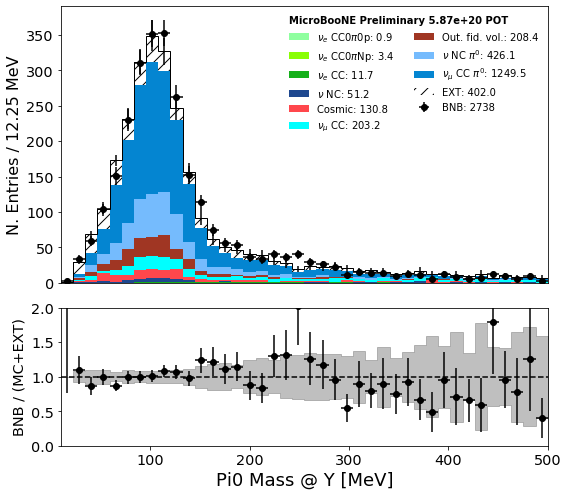

In [22]:
LAB = r"$E_{\pi}(1-\cos\theta_{\pi})$"
BOOST = r"$\cos\theta_{\gamma}^{CM}$"

VARIABLE, BINS, RANGE, XTIT = 'pi0_mass_Y',40,(10,500),r"Pi0 Mass @ Y [MeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY + "and category != 111 and (_opfilter_pe_beam > 0 or bnbdata == 1 or extdata == 1)",
    kind="event_category",
    #kind="interaction",
    #kind="sample",
    #kind='particle_pdg',
    draw_sys=True,
    stacksort=1,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

#print("Profile likelihood: %.2f sigma @ 1.32e21 POT" % my_plotter.significance_likelihood)
#print("s/sqrt(b): %.2f sigma @ 1.32e21 POT" % my_plotter.significance)
#ax1.plot(x_v,y_v1,'r--',lw=3)
#ax1.plot(x_v,y_v2,'r--',lw=2)
#ax1.set_ylim(1,ax1.get_ylim()[1]*1.1)
#ax1.axvline(145.,color='r',linestyle='--')
#ax1.set_ylim(0,200)
#ax1.set_yscale("log")
#ax1.set_ylim(0,0.25)
#ax2.set_ylim(0.5,1.5)
#fig.savefig(ls.main_path+"pi0/plots/"+VARIABLE+"_"+date_time+"_pi0sel.pdf")

In [ ]:
FNAME  = 'data_bnb_mcc9.1_v08_00_00_25_reco2_ALL_pi0_reco2'
    
fout = open(ls.main_path+DATAFLDR+FNAME+'.txt','w')
dfsel = data.query(QUERY)
if (i == 1):
    dfsel = dfsel.query(NU_Q)
print ('file %s has %i selected entries'%(FNAME,dfsel.shape[0]))
for i,row in dfsel.iterrows():
    run = row['run']
    sub = row['sub']
    evt = row['evt']
    fout.write('%i %i %i \n'%(run,sub,evt))
fout.close()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize=(6,6))
mcpi0 = mc.query('npi0 == 1')
mcpi0 = mcpi0.query(QUERY)
print (mcpi0.shape)
BINS = np.linspace(0.135,0.6,50)
BINS2D = (BINS,BINS)
plt.hist2d(mcpi0['pi0_e'].values,mcpi0['pi0energy'].values/1e3,bins=BINS2D)
plt.xlabel('true $\pi^0$ energy [GeV]',fontsize=16)
plt.ylabel('reco $\pi^0$ energy [GeV]',fontsize=16)
plt.plot(BINS,BINS,'r--',lw=4)
plt.show()

In [ ]:
datasel = data.query(QUERY)
print ((datasel['run'].values)[:10])
print ((datasel['sub'].values)[:10])
print ((datasel['evt'].values)[:10])

In [ ]:
def Eff(df,var,query,acceptance,bin_edges,absval=False):
    #print acceptance
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = '%s > %f and %s < %f'%(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        if (acceptance != ''): bincut += ' and %s'%acceptance
        #print bincut
        df_tmp =  df.query(bincut) # cut on bin range for desired var.
        df_sub = df_tmp.query(query) # apply constrain 
        if (df_tmp.shape[0] == 0): continue
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
        #print 'eff = %.02f @ bin = %.02f'%(eff,bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [ ]:
fig = plt.figure(figsize=(8,6))
B = np.linspace(0.0,0.8,25)

ACCEPTANCE = 'pi0_e > 0 and ccnc==0'
#QUERY = SELQUERY
VAR = 'pi0_e' #'_pi0_e'

centers,vals,errs = Eff(ccpi0,VAR,QUERY,ACCEPTANCE,B)
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='b',label=r'$\pi^0$ selection [CC]')

ACCEPTANCE = 'pi0_e > 0 and ccnc==1'
#QUERY = SELQUERY
VAR = 'pi0_e' #'_pi0_e'

centers,vals,errs = Eff(nc,VAR,QUERY,ACCEPTANCE,B)
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='r',label=r'$\pi^0$ selection [NC]')

plt.xlabel(r'$\pi^0$ Energy [GeV]',fontsize=16)
plt.ylabel(r'Efficiency',fontsize=16)
plt.grid()
plt.ylim([0,0.7])
plt.legend(loc=9,fontsize=16,framealpha=1.0)
#plt.yscale('log')
#plt.title(r'v08_00_00_26 Run1 Samples')
#plt.legend(loc=7,fontsize=14)
plt.show()